# The COVID-19 pandemic

This notebook uses the NYT github repository to analyze the progression of COVID-19 throughout the US states. **The analyses contained herein are not meant to be used as primary literature on their own, and may have mistakes**. I make no claims as to the accuracy of my calculations.

The questions I am interested in asking regarding this pandemic are fairly straightforward:
    * What is the case fatality rate through time?
    * What do the case / death curves look through time?
    * Are the curves flattening?

I have used the 2019 population census projections to normalize data by population, and I also used the census bureau areas to compute population density.

In [1]:
 import datetime as dt
today = dt.datetime.now() 
print('This notebook was last updated on', today.strftime('%A %B %D at %H:%M'))

This notebook was last updated on Friday April 04/17/20 at 10:03


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc
from scipy.signal import savgol_filter

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sys.path.append('./utils')

# see https://github.com/dangeles/dangeles.github.io/blob/master/jupyter/utils/covid_utils.py
import covid_utils as cv 

## Loading the data
You can find the spreadsheets I downloaded here: https://github.com/dangeles/dangeles.github.io/blob/master/data/

In [3]:
# load into a dataframe:
pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)
density = pd.read_csv('../data/pop_density.csv', comment='#', thousands=',')

# fetch NYT data:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

# df.date = pd.to_datetime(df.date)
pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
pop.state = pop.state.str.strip('.')
density.columns = np.append(np.array(['state']), density.columns[1:].values)

# calculate effective area per state:
density['EffArea'] = density['2010_POPULATION'].values/ density['2010_DENSITY'].values

# merge dfs:
df = df.merge(pop, left_on='state', right_on='state')
df = df.merge(density[['state', 'EffArea']], left_on='state', right_on='state')

df['density'] = df[2019] / df['EffArea']
df['normedCases'] = df.cases / df.density
df['normedPopCases'] = df.cases / df[2019]
df['normedDeaths'] = df.deaths / df.density
df['normedPopDeaths'] = df.deaths / df[2019]

# Case Fatality Rates
The plots below show the relationship between the number of cases and the number of deaths per state. The case fatality rate is defined as the fraction of COVID-19 infected individuals who pass away from the disease. In the graphs below, it's clear that as the number of cases has grown in New York, New Jersey and Massachusetts, so have the case fatality rate. The reason behind this relationship is unclear to me, but I suspect it has to do with decreasing quality of care as the system is overloaded.

An important point in the future will be the presence (or lack thereof) of hysteresis in the system. That is, as cases fall, will the death rate follow the same trajectory as it did before, falling back down to 1% initially? Unfortunately, I suspect that once the death rate is high, it will take a significant fall in the number of cases to bring it back down. I could very well be wrong about that, particularly if cheap and ample pharmacological supply becomes available.

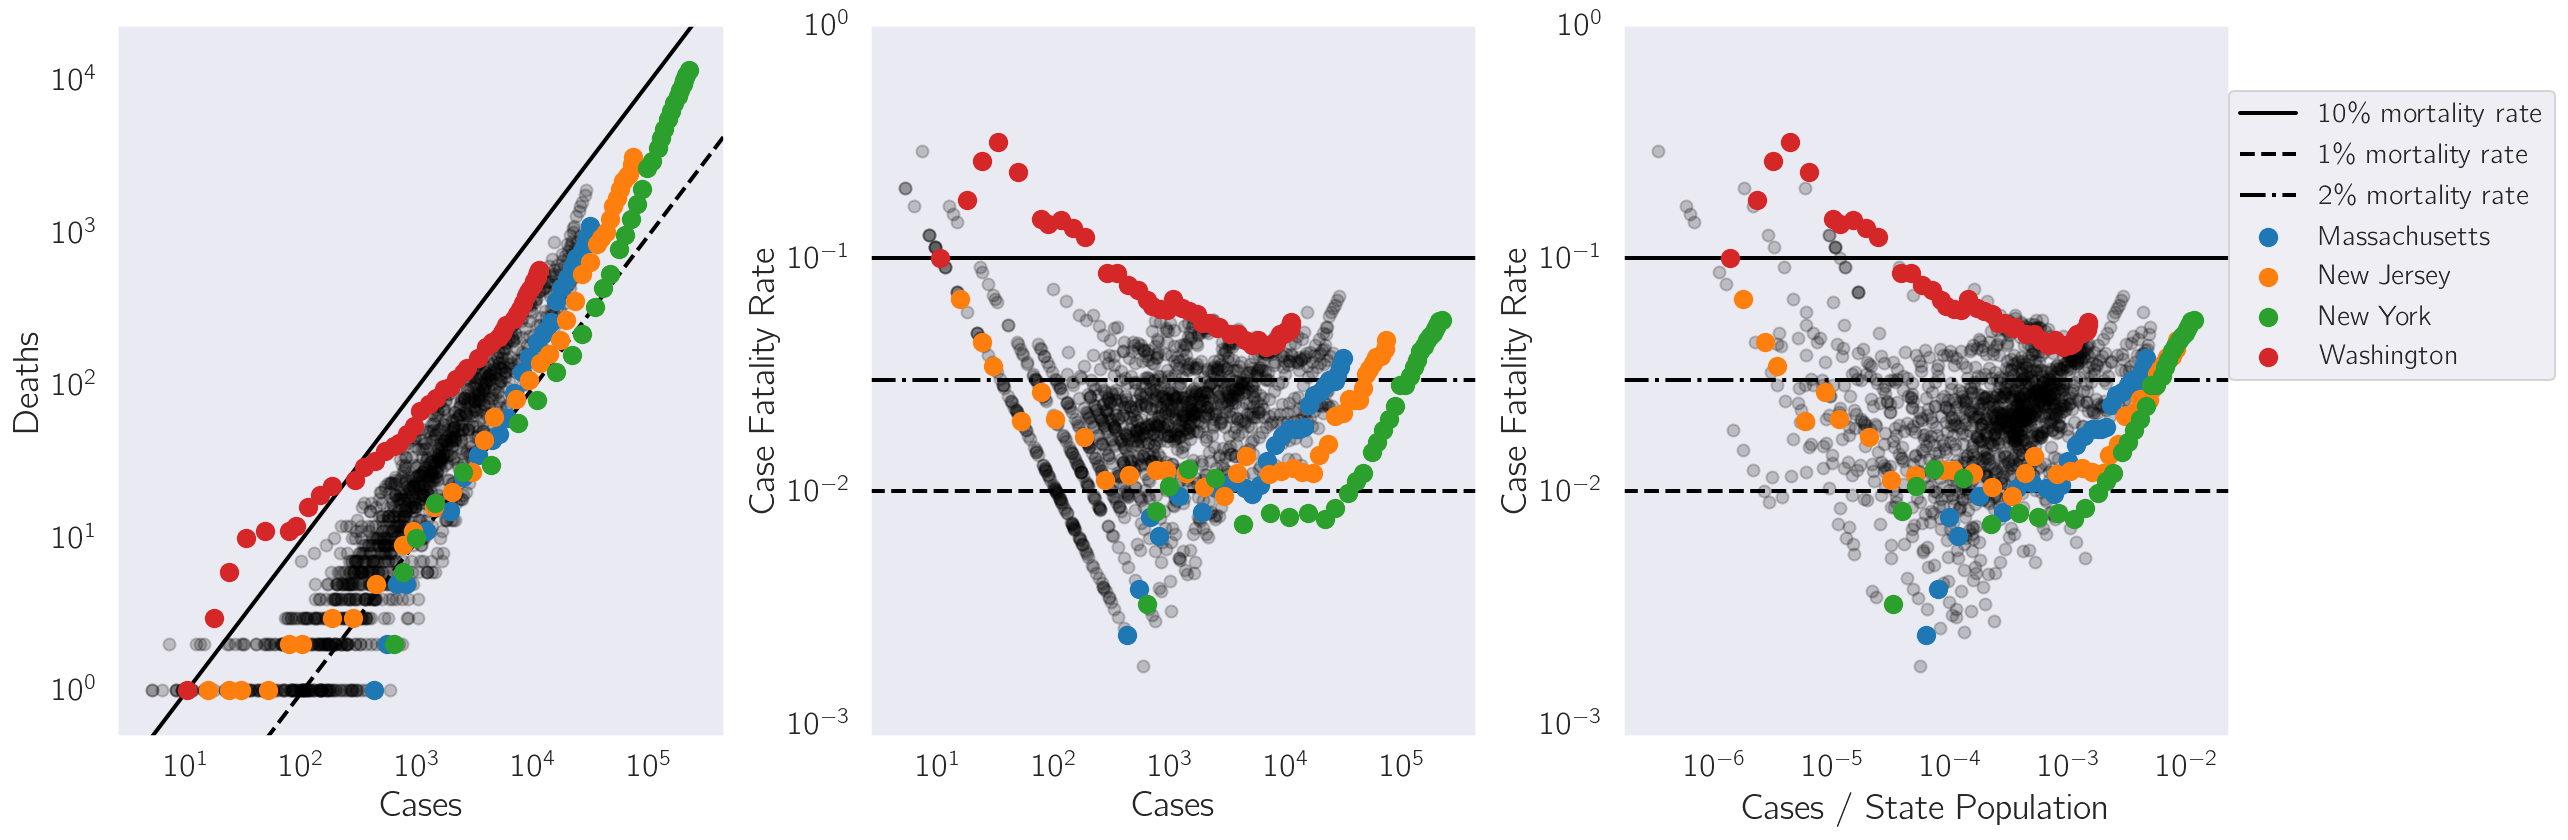

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

ax[0] = cv.plot_cases_vs_deaths(df, ax=ax[0])
ax[1] = cv.plot_cases_vs_deaths(df, CFR=True, ax=ax[1])
ax[2] = cv.plot_cases_vs_deaths(df, xcol='normedPopCases', ycol='normedPopDeaths', CFR=True, ax=ax[2])
_ = ax[2].legend(loc=(1, .5))
ax[2].set_xlabel('Cases / State Population')
plt.tight_layout()

# Epidemiological curves of COVID-19

I have plotted the cases and deaths through time in the plots below in *3 different ways*. The first column shows the absolute number of cases (first row) or deaths (second row). The second column shows the number of cases (deaths) normalized to the population of each state. The second column can be interpreted as your risk of getting COVID-19 through time for any given state, since it tells you the number of cases (or deaths) per million people for each state. Finally, the last column normalizes the number of cases (deaths) by the average population density of each state. This last column is quite interesting, and the units get funky ($infections \cdot km^2 / person$). The theory behind this is that the pandemic growth is directly dependent on the frequency of contacts between susceptible individuals and infected individuals, so normalizing by density should... do something? I mean, it is interesting that this kind of normalization drives California, Massachussets, Washington and New Jersey together. At any rate, it was an interesting idea, but I'm not sure what the results show. 

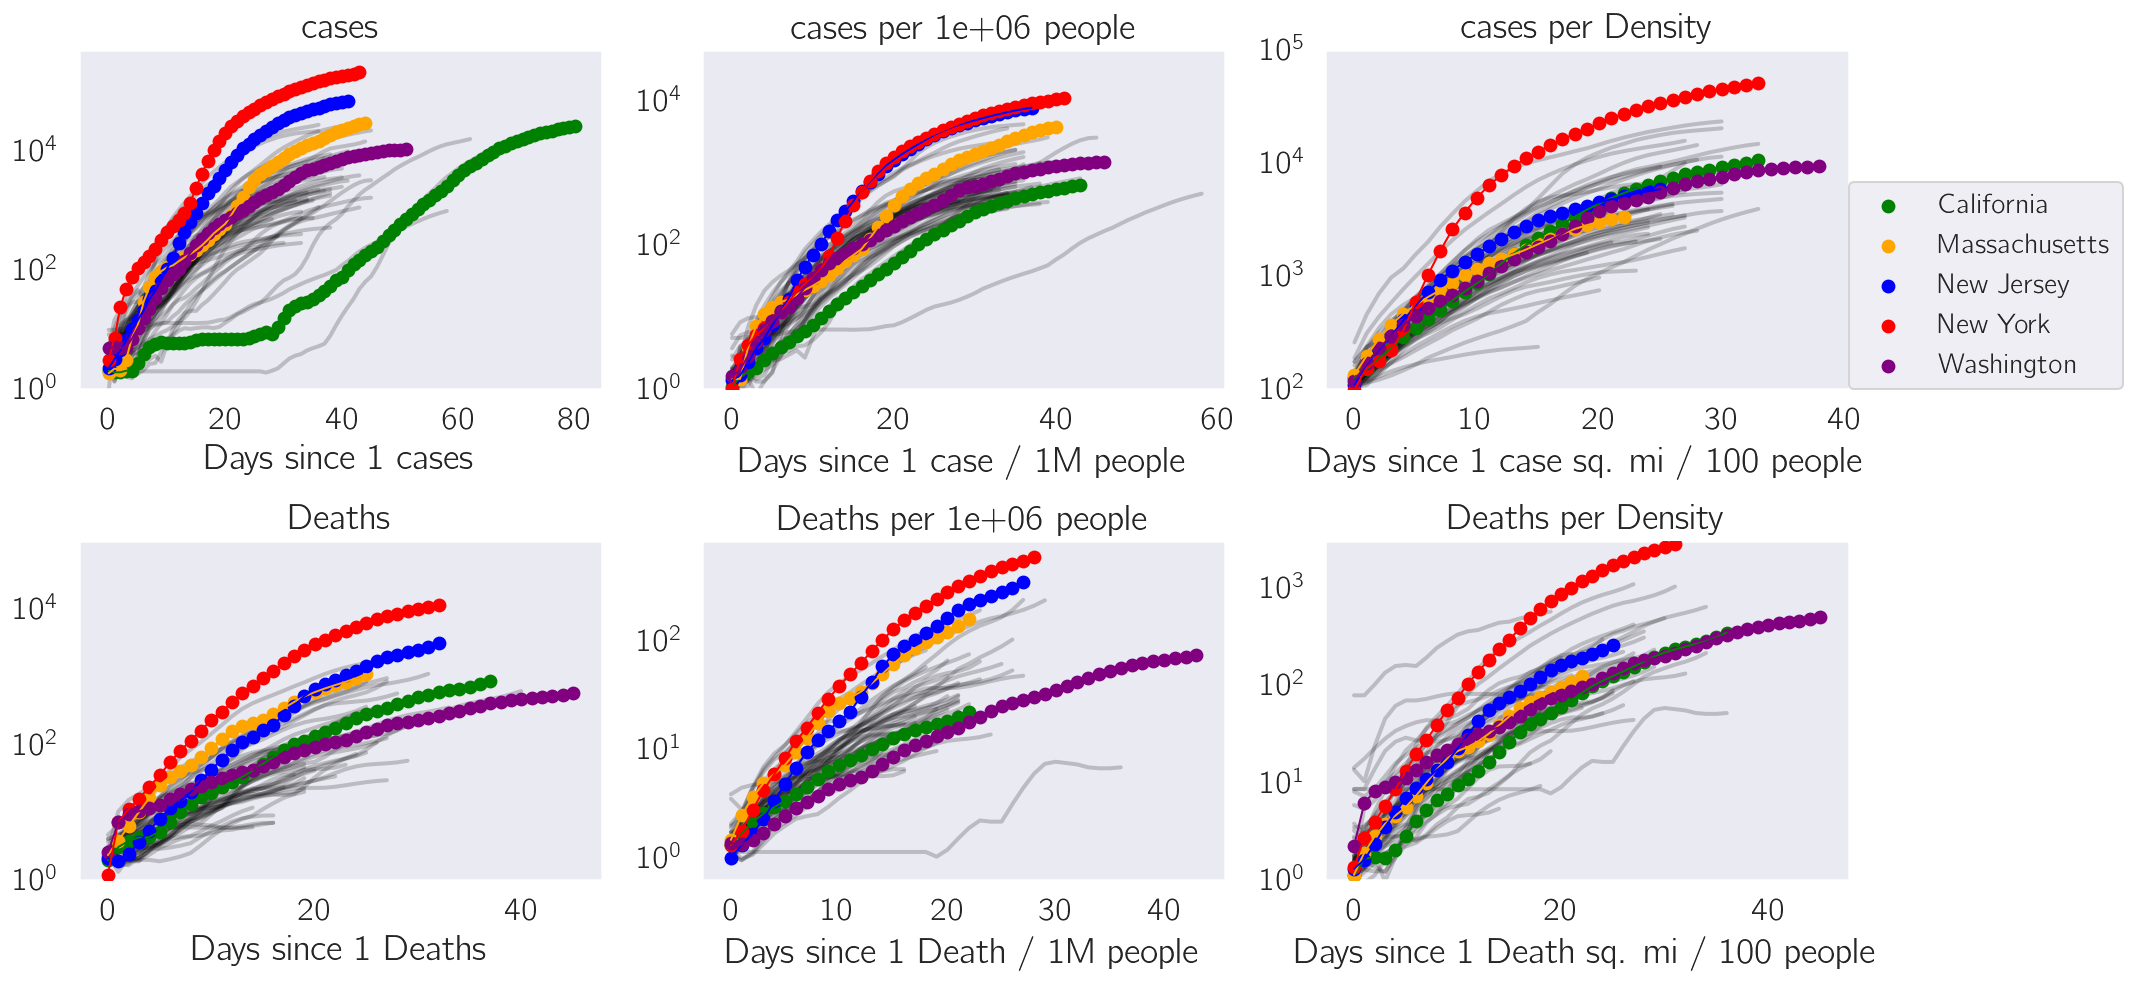

In [5]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 7))
ax[0, :] = cv.plot(ax[0], df, 'cases', 'normedPopCases', 'normedCases', n1=1, alpha=0.2)
ax[1, :] = cv.plot(ax[1], df, 'deaths', 'normedPopDeaths', 'normedDeaths', 1, 10 ** -6, 10 ** -2, ylab='Death', alpha=0.2)

# set y limits
ax[0, 0].set_ylim(1, 5 * 10**5)
ax[0, 1].set_ylim(1, 5 * 10 ** 4)
ax[0, 2].set_ylim(100, 1 * 10 ** 5)
ax[1, 0].set_ylim(1, 10**5)
ax[1, 2].set_ylim(1, 3 * 10 ** 3)
ax[0, 2].legend(loc=(1, 0))

for ai in ax:
    for aij in ai:
        aij.set_yscale('log')
plt.tight_layout()

# Are the curves flattening?

I hope so. The case curves show a lot of noise, but the death curves are quite smooth, and it seems they have plateaued. However, a plateau still means we are getting viral spread. As of today, there is not a single US state that has a net growth rate $\leq 0$, so the pandemic is still, formally, growing.

The curves below show that New York is in a class of its own and is growing much faster than anywhere else in the country.

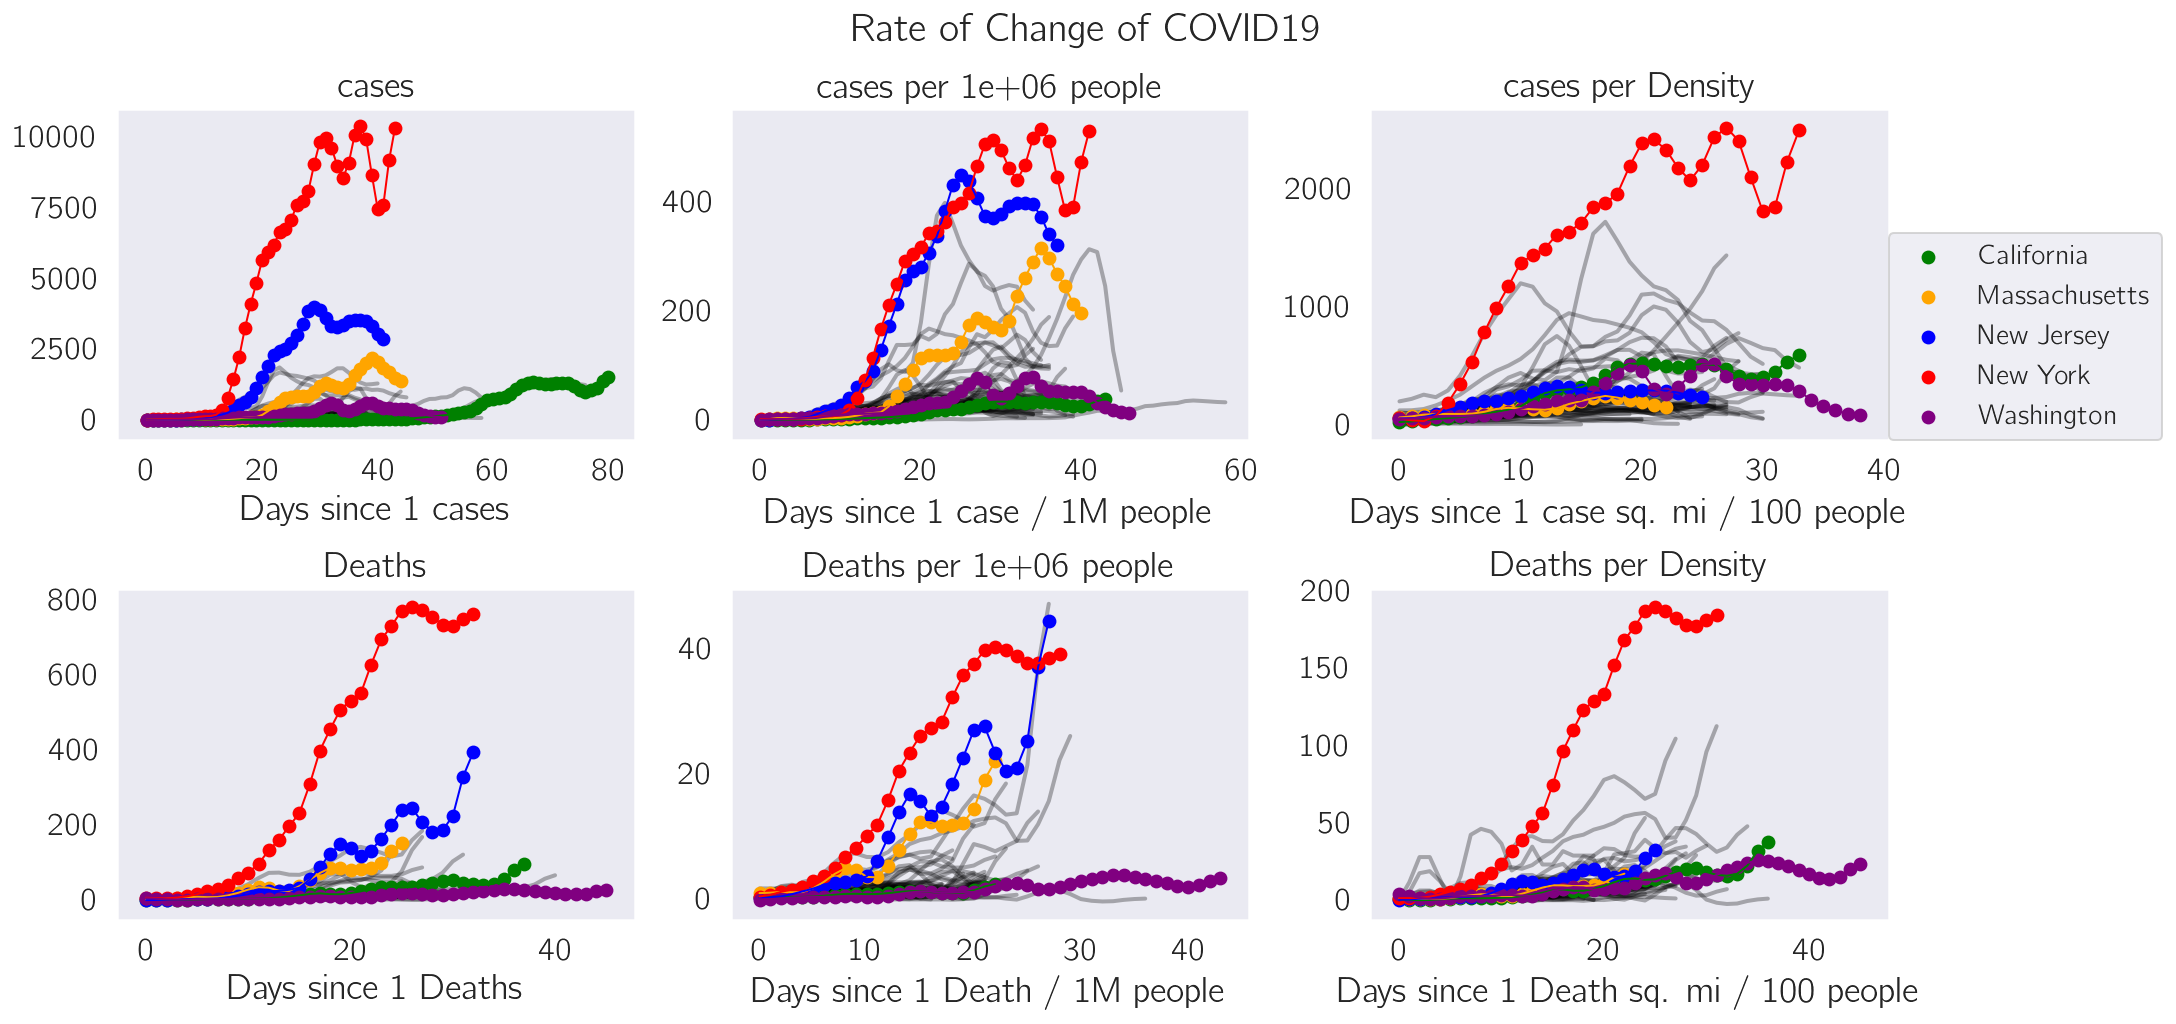

In [6]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 7), constrained_layout=True)

fig.suptitle('Rate of Change of COVID19', fontsize=20)
ax[0, :] = cv.plot(ax[0], df, 'cases', 'normedPopCases', 'normedCases', n1=1, gradient=True)
ax[1, :] = cv.plot(ax[1], df, 'deaths', 'normedPopDeaths', 'normedDeaths',
                   1, 10 ** -6, 10 ** -2, ylab='Death', gradient=True)

_ = ax[0, 2].legend(loc=(1, 0))        

Next, I have scaled each derivative by its maximum so that we can visualize all the curves more or less simultaneously. These graphs suggest that the derivatives are still positive, but the derivatives seem to have stopped growing which is at least positive! That means we are hopefully in linear or sub-linear growth regime.

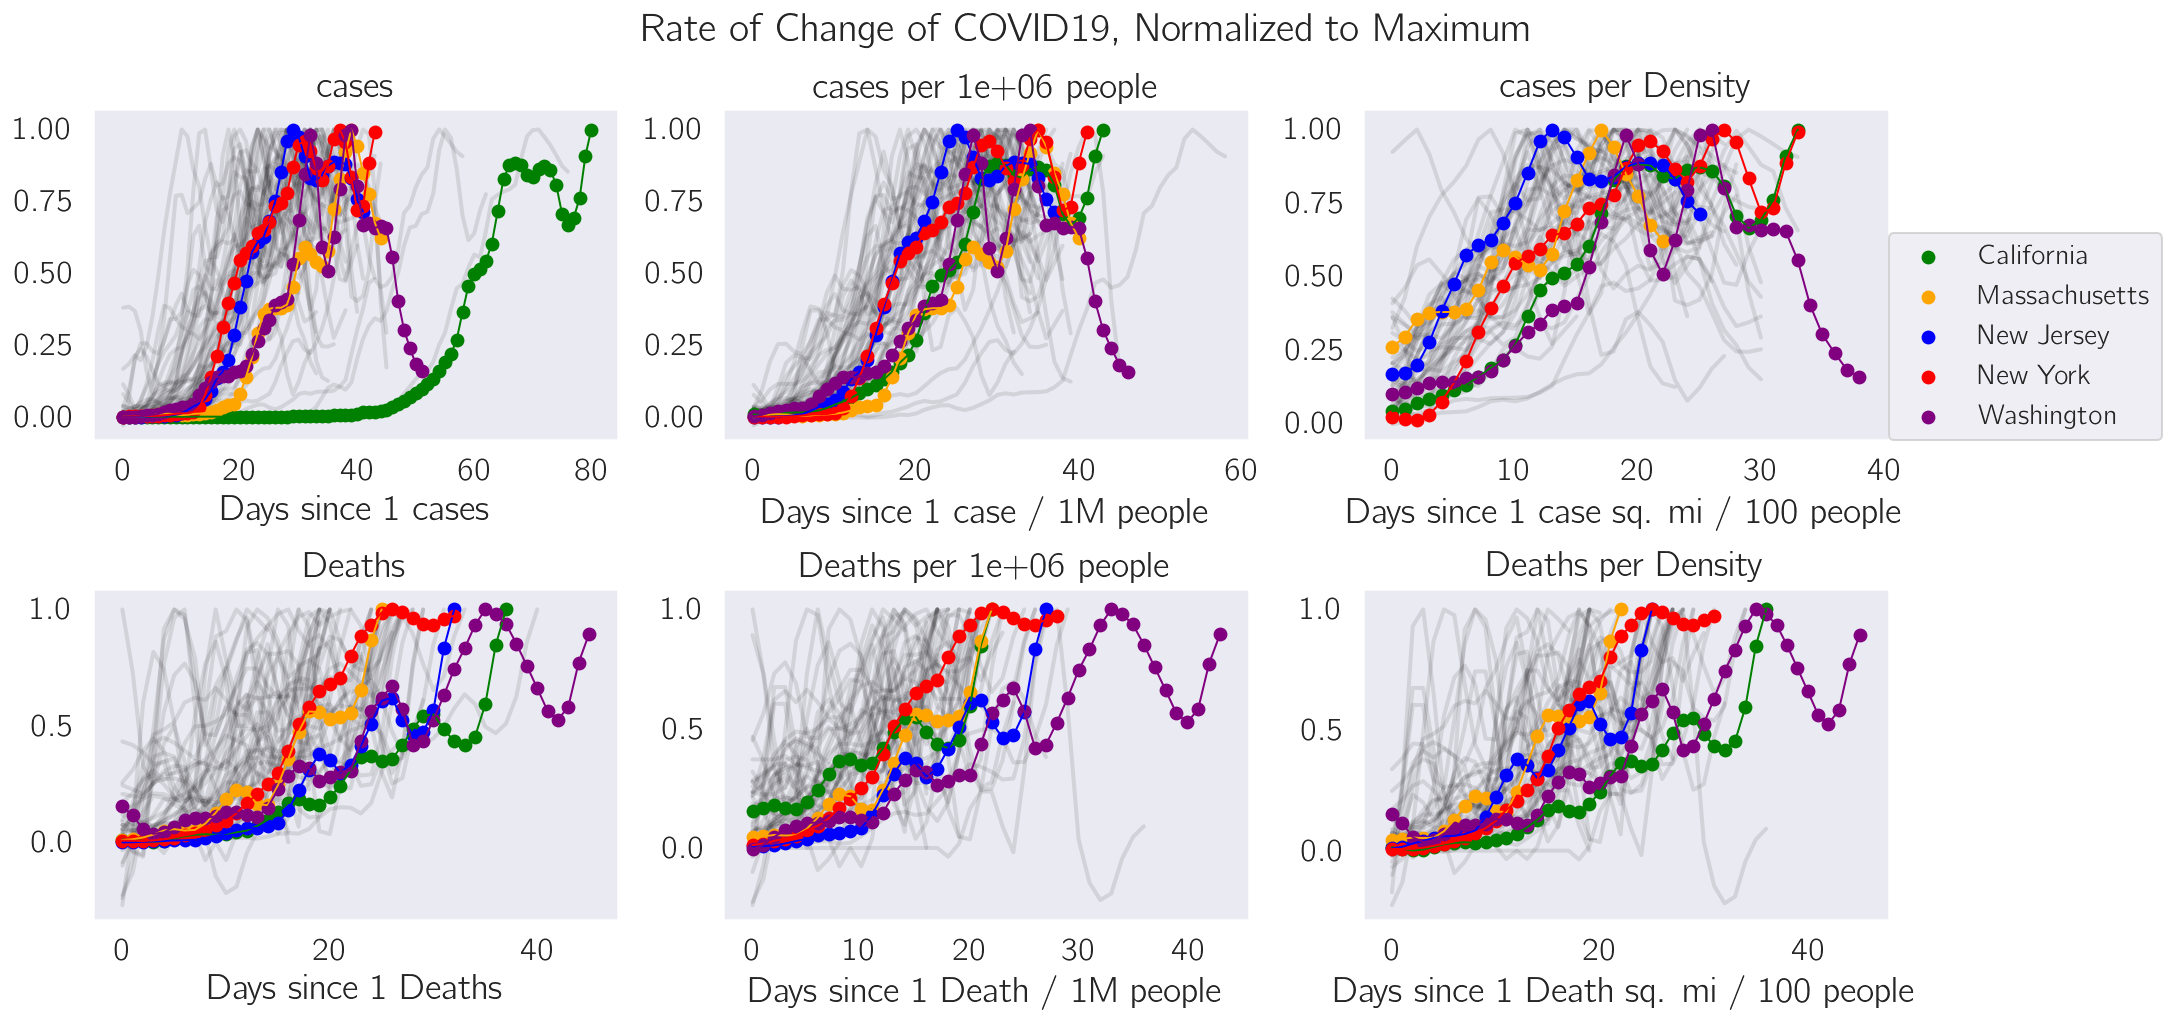

In [7]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 7), constrained_layout=True)

fig.suptitle('Rate of Change of COVID19, Normalized to Maximum', fontsize=20)
ax[0, :] = cv.plot(ax[0], df, 'cases', 'normedPopCases', 'normedCases', n1=1, gradient=True, max_norm=True, alpha=0.1)
ax[1, :] = cv.plot(ax[1], df, 'deaths', 'normedPopDeaths', 'normedDeaths',
                   1, 10 ** -6, 10 ** -2, ylab='Death', gradient=True , max_norm=True, alpha=0.1)

_ = ax[0, 2].legend(loc=(1, 0))

Here are the same graphs on a log plot, showing just how far away we are from getting these derivatives to 0, or negative.

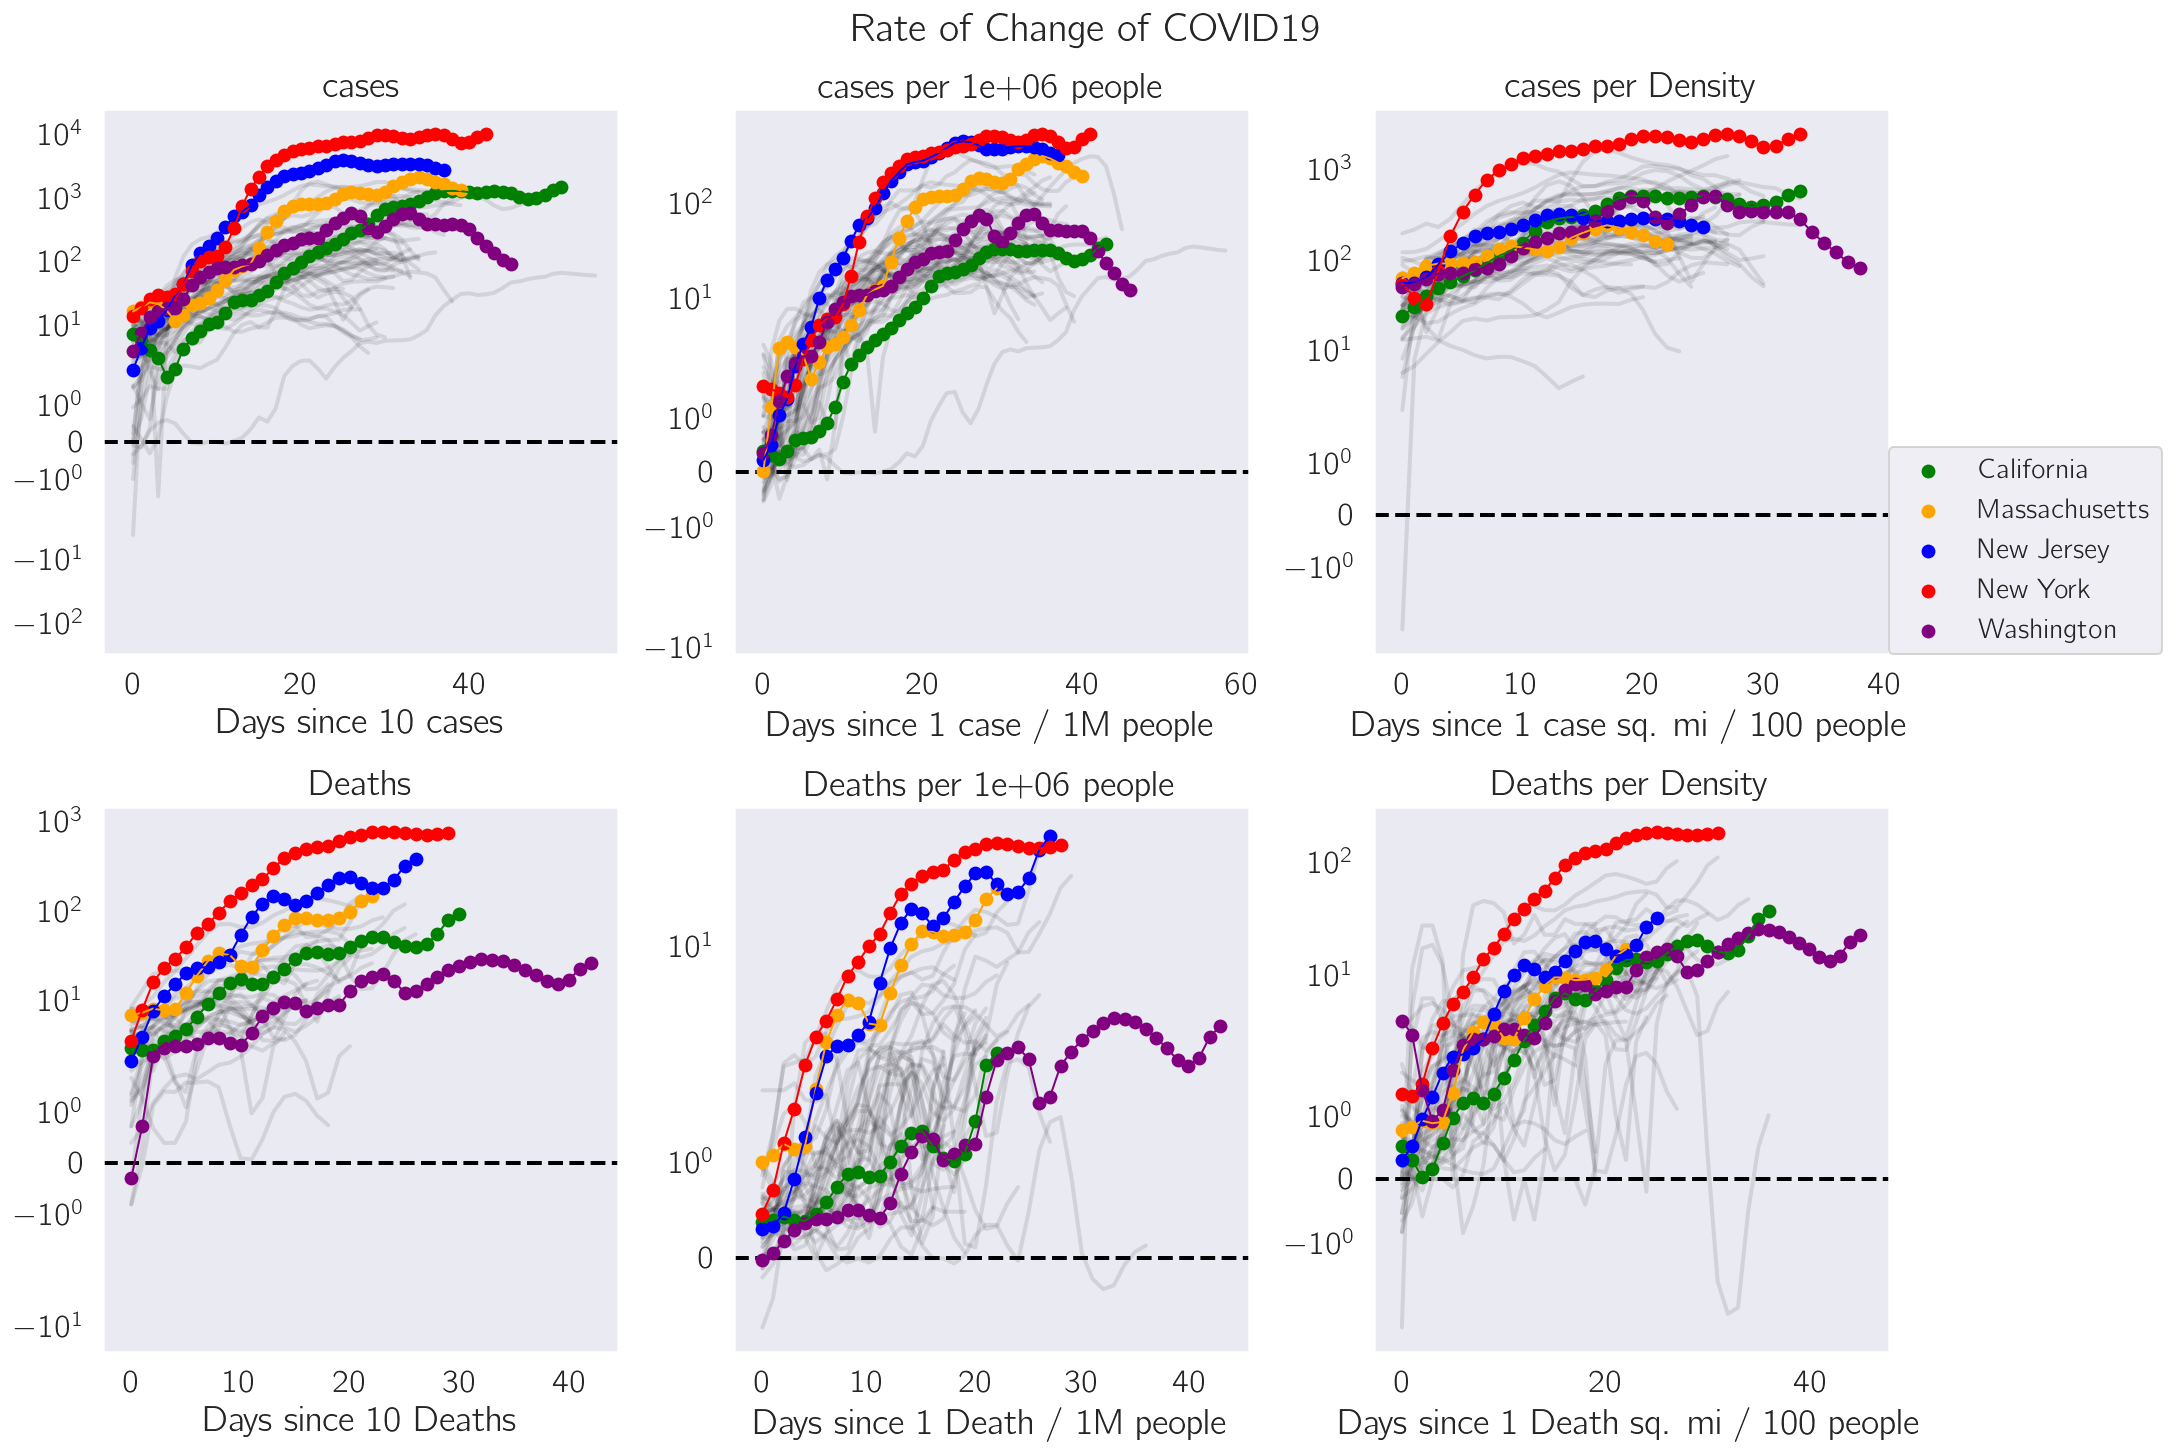

In [8]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), constrained_layout=True)

fig.suptitle('Rate of Change of COVID19', fontsize=20)
ax[0, :] = cv.plot(ax[0], df, 'cases', 'normedPopCases', 'normedCases', n1=10, gradient=True, alpha=0.1)
ax[1, :] = cv.plot(ax[1], df, 'deaths', 'normedPopDeaths', 'normedDeaths',
                   n1=10, n2=10 ** -6, n3=10 ** -2, ylab='Death', gradient=True, alpha=0.1)
ax[0, 2].legend(loc=(1, 0)) 

for ai in ax:
    for aij in ai:
        aij.axhline(0, color='black', ls='--')
        aij.set_yscale('symlog')